# Import packages

Required to be able to import the packages from the virtual environment

In [1]:
import sys

In [2]:
if "virtual_env" in sys.prefix: # only if we are in the virtual environment
    sys.path.insert(1, '/Users/benzekry/work/marseille/neuroblastome_andre/code/virtual_env/lib/python3.7/site-packages')

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.options.display.float_format = '{:,.4g}'.format
import model as model_m
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
# Pay attention that the version of stat_tools_python depends on the environment: 
# - manually installed in the virtual_env
# - from ~/work/code when run globally
from stat_tools_python.cox_regression import cox_regression
from stat_tools_python.survival_analysis import log_rank_threshold
import pickle
from packaging import version

# Load data

In [4]:
df = pd.read_excel("../data/2019_08_27_database.xls", index_col=0)
df = df.drop(23) # patient 22 removed because no data on PT dimensions
if  df['sexe'].str.contains("fille").sum() >0:
    df['sexe'] = (df['sexe']=="fille")*1
df = df.rename(columns={"age(mois)": "age"})
df = df.rename(columns={"sexe": "sex"})
df = df.loc[df.index.dropna()] # drop last 2 rows that were used in excel file to compute median

Remove patients with positive MIBG but no SIOPEN

In [5]:
idx_MIBG_1 = (df['MIBG_neg'] == 1)
print(sum(idx_MIBG_1))
df         = df.loc[~idx_MIBG_1, :]

3


Compute tumor size

In [6]:
for idx in df.index:
    diam_1     = df.loc[idx, 'T1(mm)']
    diam_2     = df.loc[idx, 'T2(mm)']
    diam_3     = df.loc[idx, 'T3(mm)']
    if np.isnan(diam_3): # if only two diameters, assume the smallest of the first two as third value
        diam_3 = min(diam_1, diam_2)
    S_diag_mm3 = 4/3*np.pi*diam_1/2*diam_2/2*diam_3/2 # (mm3)
    df.loc[idx, 'S_diag_cm3'] = S_diag_mm3/1000

Export cleaned data

In [7]:
df.to_csv("../data/data_clean.csv")

Create output directory

In [8]:
output_dir_glob = "mechanistic"
if not os.path.exists(output_dir_glob):
    os.mkdir(output_dir_glob)

# Test model

In [9]:
data  = model_m.Data()
model = model_m.Model()
model.parameters.mu                = 1e-3
model.parameters.visible_threshold = 5
model.parameters.phi               = 1e-9
M     = model.metastatic_burden(model.parameters, model.T_diag)
N_vis = model.metastatic_number_visible(model.parameters, model.T_diag)
model_LDH = model.model_LDH(model.parameters, data)
print("SIOPEN patient 1 = %.3g" % data.SIOPEN)
print("N_vis = %.3g" % N_vis)
print("LDH patient 1 = %.3g" % data.LDH)
print("LDH model = %.3g" % model_LDH)
print("M = %.3g" % M)
print("S patient 1 = %.3g" % data.S_diag)

SIOPEN patient 1 = 51
N_vis = 50.4
LDH patient 1 = 1.18e+03
LDH model = 1.24e+03
M = 9.41e+10
S patient 1 = 1.14e+12


# Fit individual

Fit each patient individually (see additional for population-level fits)

Settings

In [10]:
param_opt_indiv_names_to_idx = {'mu': 0, 'visible_threshold':1} # 'phi': 1 # correspondance between names and indices of parameters
param_opt_indiv_0            = [1e-3, 5]
param_opt_pop_names_to_idx   = {}
param_opt_pop_0              = []
model                        = model_m.Model()
model.parameters.visible_threshold = 5   # 118.5 # fitted at population level with sum min # 90 # 26.96
model.parameters.phi               = 1e-9 # 1.198e-9 # fitted at population level with sum min # 1e-9 # 4.565e-10
model.param_opt_indiv_names_to_idx = param_opt_indiv_names_to_idx
model.param_opt_pop_names_to_idx   = param_opt_pop_names_to_idx
model.set_param_opt_idx_to_names()

Launch fit

In [11]:
df_fit                             = pd.DataFrame(index=df.index)
for idx_patient in df.index:
    print('------------------------------------------')
    print('Patient %d' % idx_patient)
    data              = model_m.Data()
    data.parse_df(df, idx_patient)
    params_fit, l_fit = model_m.fit_SIOPEN_LDH(data, model, param_opt_indiv_0)
    for idx, param_fit in enumerate(params_fit):
        param_name                      = model.param_opt_indiv_idx_to_names[idx]
        df_fit.loc[idx_patient, param_name] = param_fit
    if "visible_threshold" not in param_opt_indiv_names_to_idx.keys():
        df_fit.loc[idx_patient, "visible_threshold"] = model.parameters.visible_threshold
    if "phi" not in param_opt_indiv_names_to_idx.keys():
        df_fit.loc[idx_patient, "phi"] = model.parameters.phi
    df_fit.loc[idx_patient, "loglik"]   = l_fit
    df_fit.loc[idx_patient, "loglik"]   = l_fit
    l, l_SIOPEN, l_LDH, model_SIOPEN, M, model_LDH = model_m.loglik_SIOPEN_LDH(params_fit, data, model, output="full")
    df_fit.loc[idx_patient, "SIOPEN"]       = data.SIOPEN
    df_fit.loc[idx_patient, "SIOPEN_model"] = model_SIOPEN
    df_fit.loc[idx_patient, "LDH"]          = data.LDH
    df_fit.loc[idx_patient, "LDH_model"]    = model_LDH
    df_fit.loc[idx_patient, "l_SIOPEN"]     = l_SIOPEN
    df_fit.loc[idx_patient, "l_LDH"]        = l_LDH
    df_fit.loc[idx_patient, "tumor_size_mm3"] = data.S_diag_mm3
df_fit.to_csv("mechanistic/df_fit_indiv.csv")

------------------------------------------
Patient 1
Optimization terminated successfully.
         Current function value: 8.230440
         Iterations: 67
         Function evaluations: 126
------------------------------------------
Patient 2
Optimization terminated successfully.
         Current function value: 9.131145
         Iterations: 61
         Function evaluations: 114
------------------------------------------
Patient 3
Optimization terminated successfully.
         Current function value: 7.317244
         Iterations: 54
         Function evaluations: 102
------------------------------------------
Patient 4
Optimization terminated successfully.
         Current function value: 8.376338
         Iterations: 75
         Function evaluations: 143
------------------------------------------
Patient 6
Optimization terminated successfully.
         Current function value: 6.429740
         Iterations: 61
         Function evaluations: 118
----------------------------------------

Post-processing

In [12]:
df_fit_indiv = pd.read_csv("mechanistic/df_fit_indiv.csv", index_col=0)
df_fit_indiv.head()

,mu,visible_threshold,phi,loglik,SIOPEN,SIOPEN_model,LDH,LDH_model,l_SIOPEN,l_LDH,tumor_size_mm3
id,,,,,,,,,,,
1,0.000303,3.36,1e-09,8.23,51,50.5,1.18e+03,1.17e+03,2.54,5.69,1.14e+06
2,0.0364,15.5,1e-09,9.13,45,44.6,3.3e+03,3.27e+03,2.42,6.71,8.25e+05
3,0.00784,8.23,1e-09,7.32,34,33.7,712,705,2.14,5.18,4.34e+05
4,0.0704,14,1e-09,8.38,39,38.6,1.79e+03,1.77e+03,2.27,6.1,2.73e+05
6,0.0118,6.79,1e-09,6.43,33,32.7,302,299,2.11,4.32,1.57e+05


Plot data versus model prediction

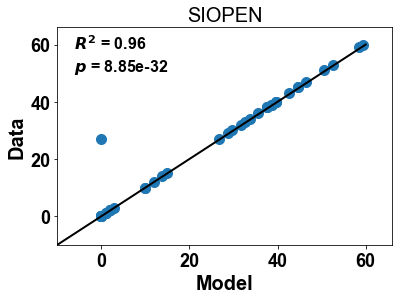

R^2 = 1
p = 2.22e-88


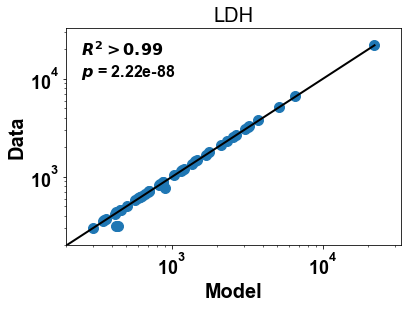

In [13]:
# from sklearn.linear_model import LinearRegression
from scipy import stats
#---------
# SIOPEN
#---------
fig, ax = plt.subplots()
plt.plot(df_fit_indiv['SIOPEN_model'], df_fit_indiv['SIOPEN'], 'o');
plt.title("SIOPEN", fontsize=20);
plt.xlabel("Model");
plt.ylabel("Data");
xlim = ax.get_xlim()
x_max = max(df_fit_indiv['SIOPEN_model'])
y_max = max(df_fit_indiv['SIOPEN'])
x_y_max = max(x_max, y_max) # 85
x_y_min = -10
ax.set_xlim([x_y_min, x_y_max*1.1])
ax.set_ylim([x_y_min, x_y_max*1.1])
ax.plot([x_y_min, x_y_max], [x_y_min, x_y_max], 'k');

# Linear regression using stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(df_fit_indiv['SIOPEN_model'], df_fit_indiv['SIOPEN'])
plt.text(x=0.05, y=0.9, s='$R^2$ = {:.3g}'.format(r_value**2), transform=ax.transAxes, fontsize=16)
plt.text(x=0.05, y=0.8, s='$p$ = {:.3g}'.format(p_value), transform=ax.transAxes, fontsize=16)
plt.savefig('mechanistic/fit_SIOPEN.pdf', bbox_inches='tight')
plt.show()


#---------
# LDH
#---------
fig2, ax2 = plt.subplots();
plt.loglog(df_fit_indiv['LDH_model'], df_fit_indiv['LDH'], 'o');
plt.title("LDH", fontsize=20);
plt.xlabel("Model");
plt.ylabel("Data");
x_max = max(df_fit_indiv['LDH_model'])
y_max = max(df_fit_indiv['LDH'])
x_y_max = max(x_max, y_max)
x_y_min = 2e2
ax2.set_xlim([x_y_min, x_y_max*1.5])
ax2.set_ylim([x_y_min, x_y_max*1.5])
ax2.plot([x_y_min, x_y_max], [x_y_min, x_y_max], 'k');

# Linear regression using stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(df_fit_indiv['LDH_model'], df_fit_indiv['LDH'])
print("R^2 = %.3g" % r_value**2)
print("p = %.3g" % p_value)

plt.text(x=0.08, y=1, s='$R^2>0.99$', transform=ax.transAxes, fontsize=16)
plt.text(x=0.08, y=0.9, s='$p$ = {:.3g}'.format(p_value), transform=ax.transAxes, fontsize=16)
plt.savefig('mechanistic/fit_LDH.pdf', bbox_inches='tight')
plt.show()


# Survival analysis

Use next cell if fit indiv

In [14]:
df_fit          = pd.read_csv("mechanistic/df_fit_indiv.csv", index_col=0)

Use next cell instead if fit pop

In [15]:
# df_fit          = pd.read_csv("mechanistic/df_fit_pop.csv", index_col=0)

## Group analysis of the mathematical parameters (logrank)

### PFS

#### Median

------------------------------------------------
mu
------------------------------------------------


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


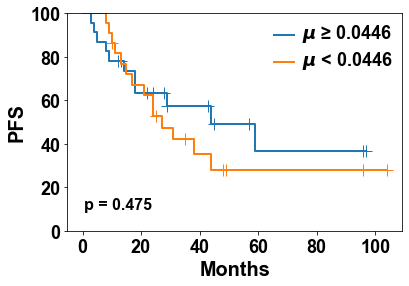

------------------------------------------------
visible_threshold
------------------------------------------------


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


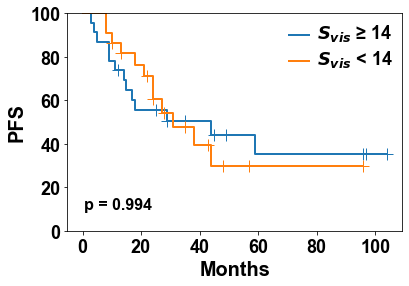

In [16]:
for param_name in model.param_opt_indiv_names_to_idx.keys():
    print('------------------------------------------------')
    print(param_name)
    print('------------------------------------------------')
    df[param_name] = df_fit[param_name]
    if param_name=='mu':
        param_name_label ='$\mu$'
    elif param_name=='visible_threshold':
        param_name_label = '$S_{vis}$'            
    log_rank_threshold(
        df,
        param_name,
        tte_name='PFS',
        event_name='progression',
        labels=[param_name_label+' < {:.3g}'.format(np.median(df[param_name])), param_name_label+' ≥ {:.3g}'.format(np.median(df[param_name]))],
        ylabel="PFS",
        output_file='mechanistic/PFS_thresholds/'+param_name+'/median',
        ci_show=False)

#### Variable percentiles

------------------------------------------------
------------------------------------------------
mu
------------------------------------------------
------------------------------------------------
------------------------------------------
Percentile = 10
value = 0.00161


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


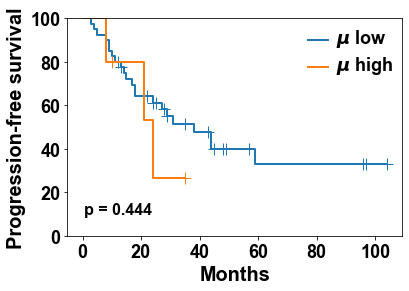

------------------------------------------
Percentile = 20
value = 0.00798


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


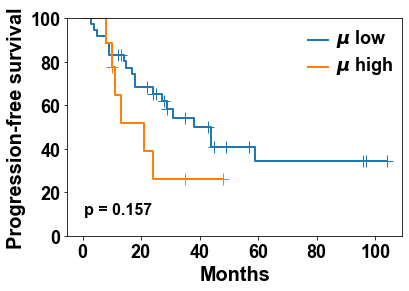

------------------------------------------
Percentile = 30
value = 0.0147


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


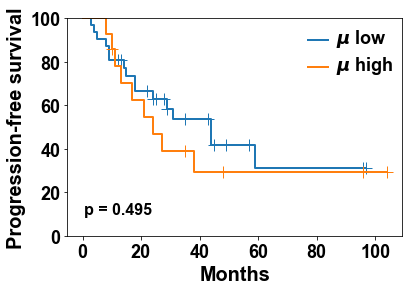

------------------------------------------
Percentile = 40
value = 0.0271


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


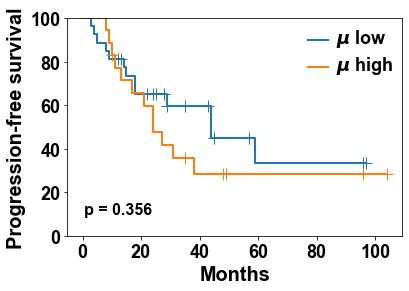

------------------------------------------
Percentile = 50
value = 0.0446


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


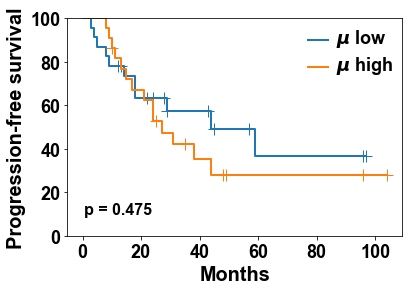

------------------------------------------
Percentile = 60
value = 0.0576


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


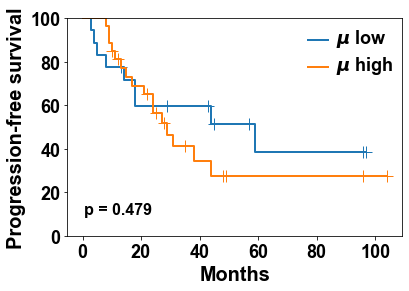

------------------------------------------
Percentile = 70
value = 0.0798


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


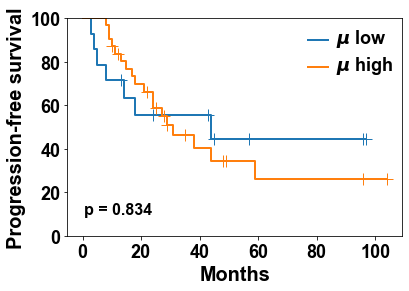

------------------------------------------
Percentile = 80
value = 0.128


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


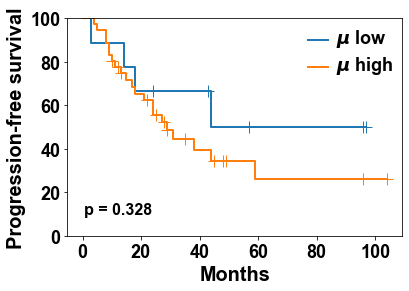

------------------------------------------
Percentile = 90
value = 0.59


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


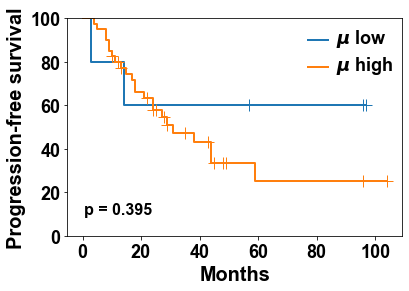

------------------------------------------------
------------------------------------------------
visible_threshold
------------------------------------------------
------------------------------------------------
------------------------------------------
Percentile = 10
value = 6.8


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


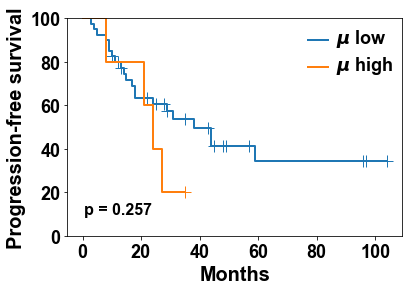

------------------------------------------
Percentile = 20
value = 8.25


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


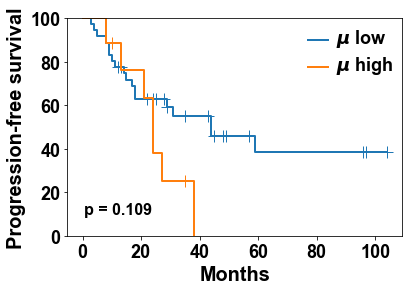

------------------------------------------
Percentile = 30
value = 9.77


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


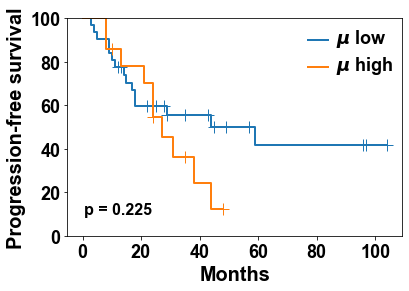

------------------------------------------
Percentile = 40
value = 11.5


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


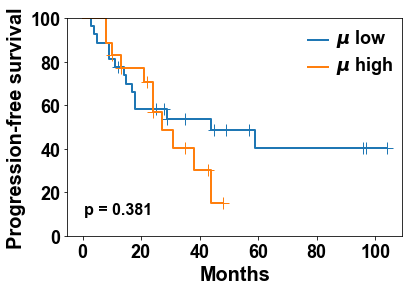

------------------------------------------
Percentile = 50
value = 14


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


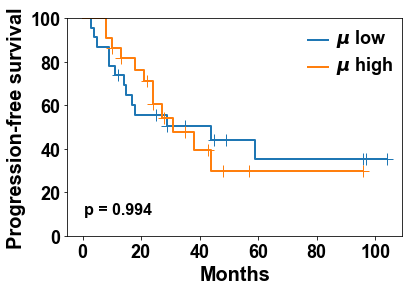

------------------------------------------
Percentile = 60
value = 19.2


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


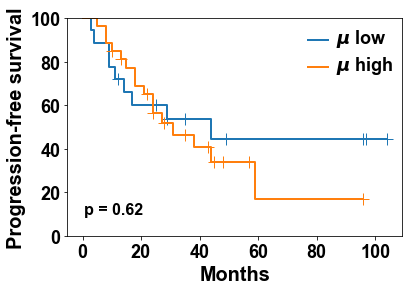

------------------------------------------
Percentile = 70
value = 36.2


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


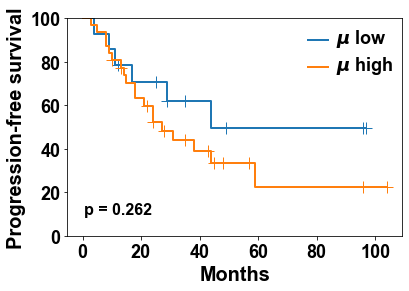

------------------------------------------
Percentile = 80
value = 69.3


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


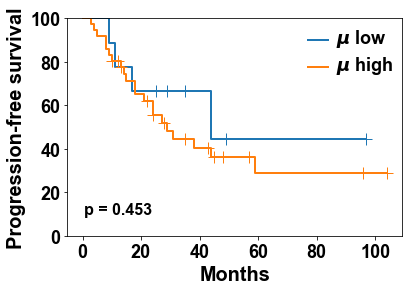

------------------------------------------
Percentile = 90
value = 113


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


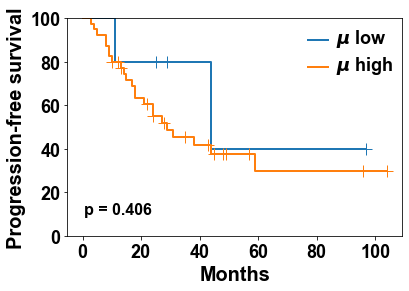

In [17]:
for param_name in model.param_opt_indiv_names_to_idx.keys():
    print('------------------------------------------------')
    print('------------------------------------------------')
    print(param_name)
    print('------------------------------------------------')
    print('------------------------------------------------')
    # create directory
    if not os.path.exists('mechanistic/PFS_thresholds/'+str(param_name)):
        os.makedirs('mechanistic/PFS_thresholds/'+str(param_name))            
    for prct in np.arange(start=10, stop=100, step=10):
        print("------------------------------------------")
        print("Percentile = %d" % prct)
        threshold = np.percentile(df[param_name], prct)
        print("value = %.3g" % threshold)
        log_rank_threshold(
            df,
            param_name,
            threshold=threshold,
            tte_name='PFS',
            event_name='progression',
            ylabel="Progression-free survival",
            output_file='mechanistic/PFS_thresholds/'+str(param_name)+'/'+str(prct),
            labels=["$\mu$ high", "$\mu$ low"],
            ci_show=False
        )

### OS

#### Median

------------------------------------------------
mu
------------------------------------------------


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


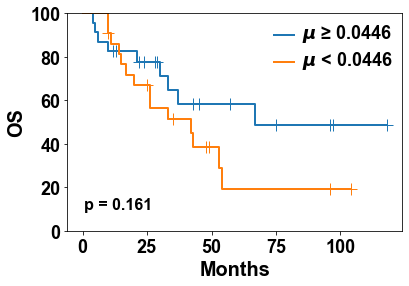

------------------------------------------------
visible_threshold
------------------------------------------------


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


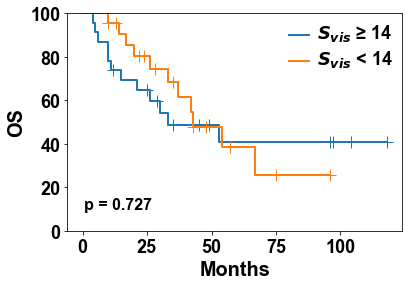

In [18]:
for param_name in model.param_opt_indiv_names_to_idx.keys():
    print('------------------------------------------------')
    print(param_name)
    print('------------------------------------------------')
    df[param_name] = df_fit[param_name]
    if param_name=='mu':
        param_name_label ='$\mu$'
    elif param_name=='visible_threshold':
        param_name_label = '$S_{vis}$'            
    log_rank_threshold(
        df,
        param_name,
        tte_name='OS',
        event_name='deces',
        labels=[param_name_label+' < {:.3g}'.format(np.median(df[param_name])), param_name_label+' ≥ {:.3g}'.format(np.median(df[param_name]))],
        ylabel="OS",
        output_file='mechanistic/OS_thresholds/'+param_name+'/median',
        ci_show=False)

#### Variable percentiles

------------------------------------------------
------------------------------------------------
mu
------------------------------------------------
------------------------------------------------
------------------------------------------
Percentile = 10
value = 0.00161


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


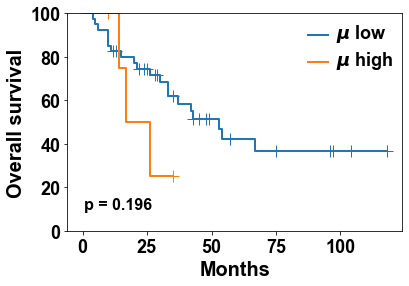

------------------------------------------
Percentile = 20
value = 0.00798


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


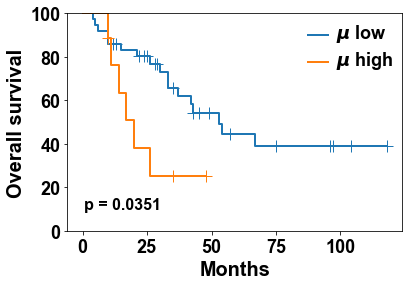

------------------------------------------
Percentile = 30
value = 0.0147


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


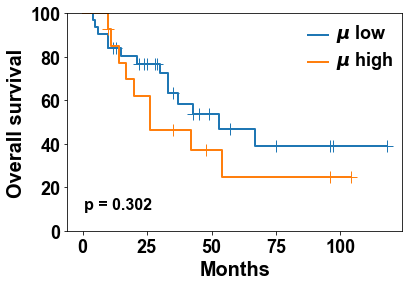

------------------------------------------
Percentile = 40
value = 0.0271


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


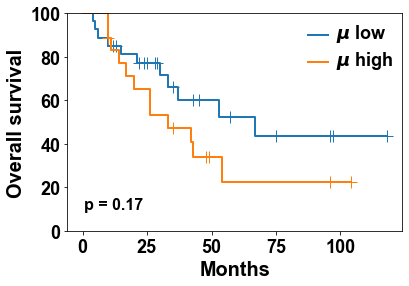

------------------------------------------
Percentile = 50
value = 0.0446


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


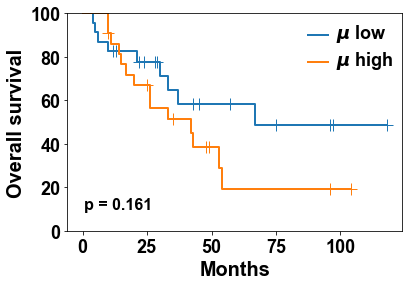

------------------------------------------
Percentile = 60
value = 0.0576


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


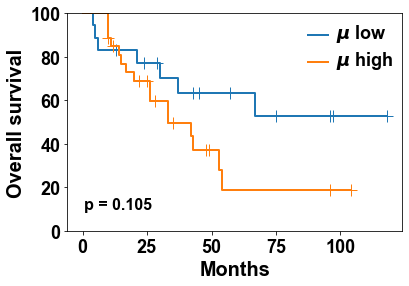

------------------------------------------
Percentile = 70
value = 0.0798


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


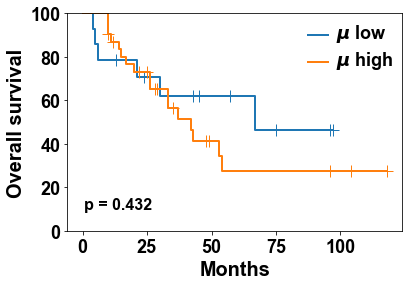

------------------------------------------
Percentile = 80
value = 0.128


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


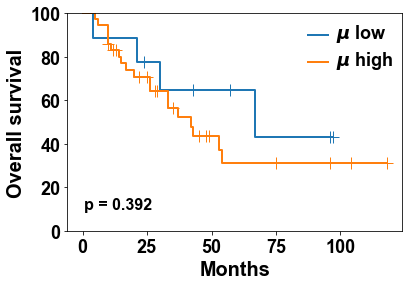

------------------------------------------
Percentile = 90
value = 0.59


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


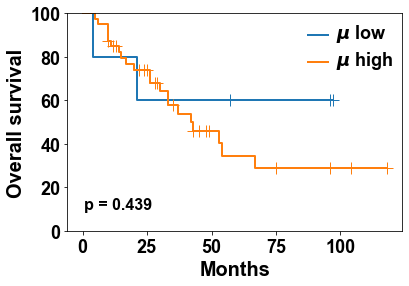

------------------------------------------------
------------------------------------------------
visible_threshold
------------------------------------------------
------------------------------------------------
------------------------------------------
Percentile = 10
value = 6.8


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


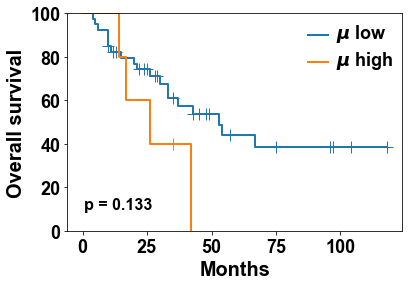

------------------------------------------
Percentile = 20
value = 8.25


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


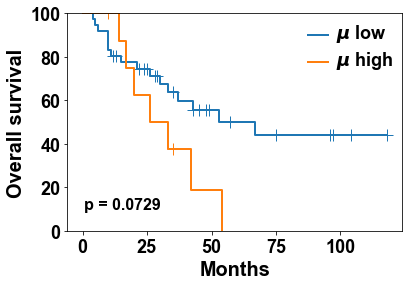

------------------------------------------
Percentile = 30
value = 9.77


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


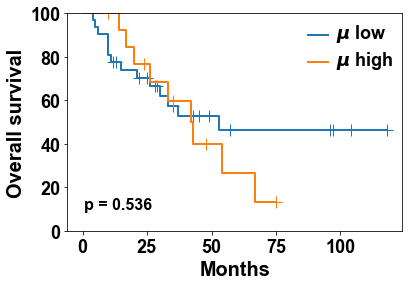

------------------------------------------
Percentile = 40
value = 11.5


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


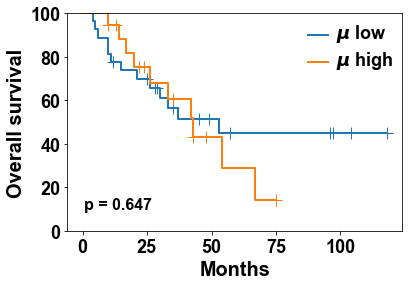

------------------------------------------
Percentile = 50
value = 14


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


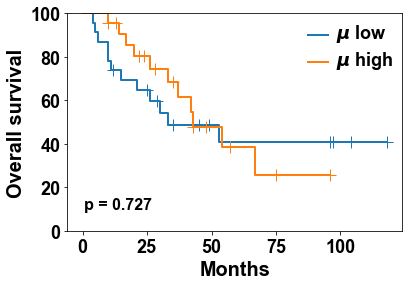

------------------------------------------
Percentile = 60
value = 19.2


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


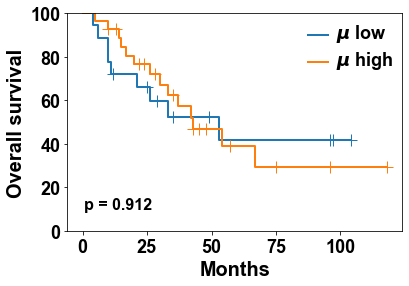

------------------------------------------
Percentile = 70
value = 36.2


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


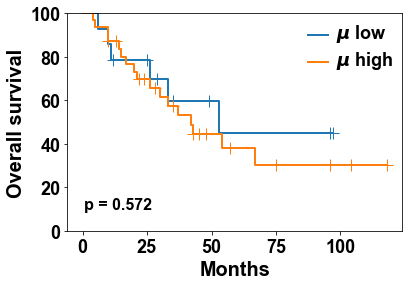

------------------------------------------
Percentile = 80
value = 69.3


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


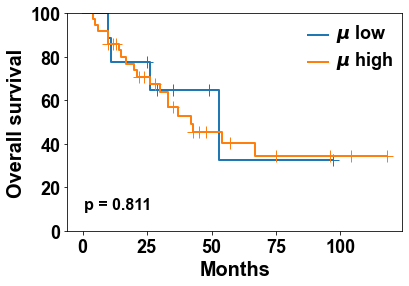

------------------------------------------
Percentile = 90
value = 113


/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


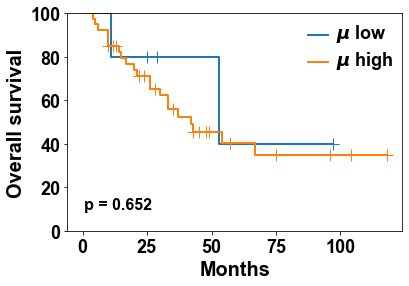

In [19]:
for param_name in model.param_opt_indiv_names_to_idx.keys():
    print('------------------------------------------------')
    print('------------------------------------------------')
    print(param_name)
    print('------------------------------------------------')
    print('------------------------------------------------')
    # create folder
    if not os.path.exists('mechanistic/OS_thresholds/'+str(param_name)):
        os.makedirs('mechanistic/OS_thresholds/'+str(param_name))    
    for prct in np.arange(start=10, stop=100, step=10):
        print("------------------------------------------")
        print("Percentile = %d" % prct)
        threshold = np.percentile(df[param_name], prct)
        print("value = %.3g" % threshold)
        log_rank_threshold(
            df,
            param_name,
            threshold=threshold,
            tte_name='OS',
            event_name='deces',
            ylabel="Overall survival",
            output_file='mechanistic/OS_thresholds/'+str(param_name)+'/'+str(prct),
            labels=["$\mu$ high", "$\mu$ low"],
            ci_show=False
        )

## Cox regression only clinical parameters

In [20]:
df['$\log(\mu)$']= np.log(df['mu'])
df['MYCN'] = df['Nmyc']
df['visible threshold']  = df['visible_threshold']
df['tumor size']= df['S_diag_cm3']
df['log(mu)']  = np.log(df['mu'])
df['log(LDH)']  = np.log(df['LDH'])
# df['log_phi'] = np.log(df['phi'])
features_clinical = [
    "age",
    "sex",
#     "LDH",
    "log(LDH)",
#     "$\log(LDH)$",
    "SIOPEN",
    "MYCN",
    'tumor size',
#     "$\log(\mu)$",
#     "log_phi"
#     "visible threshold"
#     "MIBG_neg"
    ]
df['$\log(LDH)$'] = np.log(df['LDH'])

### PFS

-----------------------------------------------------------------------
Individual features
-----------------------------------------------------------------------
age
p = 0.649
sex
p = 0.228
log(LDH)
p = 0.0385
SIOPEN
p = 0.0647
MYCN
p = 0.368
tumor size
p = 0.0651
-----------------------------------------------------------------------
All features multivariate
-----------------------------------------------------------------------
            Hazard ratio     p  coef lower 95\%  coef upper 95\%
covariate                                                       
age                0.996 0.675            0.976             1.02
sex                 1.23 0.656            0.499             3.01
log(LDH)            1.57 0.271            0.703             3.52
SIOPEN              1.02 0.174            0.991             1.05
MYCN                1.07 0.929            0.265             4.28
tumor size             1 0.404            0.999                1


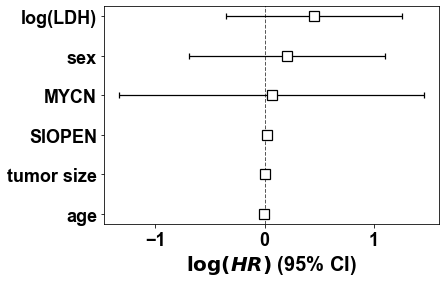


Mean (95% C.I) c-index in 5 fold cross-validation: 0.517 (0.503 - 0.53)
-----------------------------------------------------------------------
Only significant features in univariate (p < 0.2): 
['log(LDH)', 'SIOPEN', 'tumor size']
-----------------------------------------------------------------------
Only significant features
            Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                        
log(LDH)             1.6  0.116             0.89             2.89
SIOPEN              1.02 0.0637            0.999             1.04
tumor size             1  0.397                1                1


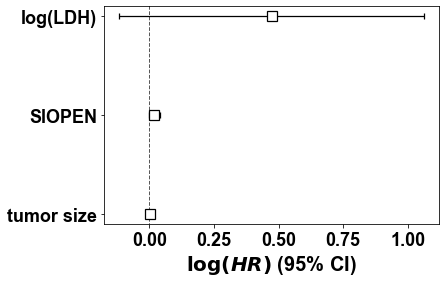


Mean (95% C.I) c-index in 5 fold cross-validation: 0.582 (0.568 - 0.595)
-----------------------------------------------------------------------
Only significant features in multivariate (p < 0.2): 
['SIOPEN']
-----------------------------------------------------------------------
Only significant features
           Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                       
SIOPEN             1.02 0.0647            0.999             1.04


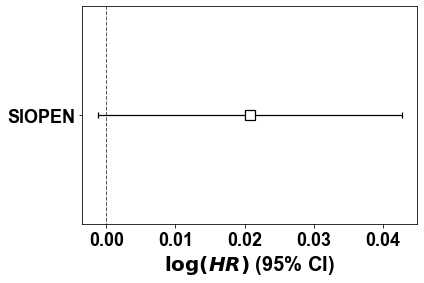


Mean (95% C.I) c-index in 5 fold cross-validation: 0.619 (0.606 - 0.632)


In [21]:
output_clinical_pfs = cox_regression(
    features_input = df[features_clinical],
    outcomes_input = df[['PFS', "progression"]],
    duration_col='PFS',
    event_col="progression",
    k_cross=5,
    n_repeats_cv=100,
    output_dir="cox_regression/pfs",
    signif_threshold=0.2,
    penalizer=0);

### OS

-----------------------------------------------------------------------
Individual features
-----------------------------------------------------------------------
age
p = 0.316
sex
p = 0.209
log(LDH)
p = 0.00794
SIOPEN
p = 0.297
MYCN
p = 0.184
tumor size
p = 0.00621
-----------------------------------------------------------------------
All features multivariate
-----------------------------------------------------------------------
            Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                        
age                    1  0.758            0.983             1.02
sex                  1.6   0.33            0.621             4.13
log(LDH)            2.21 0.0617            0.962             5.07
SIOPEN                 1  0.847            0.973             1.03
MYCN               0.604  0.498            0.141             2.59
tumor size             1  0.114                1                1


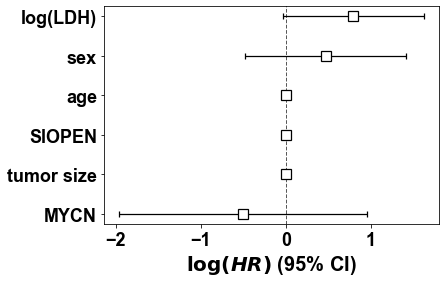


Mean (95% C.I) c-index in 5 fold cross-validation: 0.592 (0.578 - 0.606)
-----------------------------------------------------------------------
Only significant features in univariate (p < 0.2): 
['log(LDH)', 'MYCN', 'tumor size']
-----------------------------------------------------------------------
Only significant features
            Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                        
log(LDH)             2.3 0.0385             1.04             5.07
MYCN               0.509  0.283            0.148             1.75
tumor size             1 0.0517                1                1


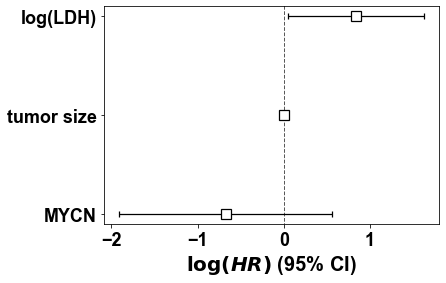


Mean (95% C.I) c-index in 5 fold cross-validation: 0.642 (0.627 - 0.656)
-----------------------------------------------------------------------
Only significant features in multivariate (p < 0.2): 
['log(LDH)', 'tumor size']
-----------------------------------------------------------------------
Only significant features
            Hazard ratio     p  coef lower 95\%  coef upper 95\%
covariate                                                       
log(LDH)            1.78 0.072             0.95             3.33
tumor size             1 0.114                1                1


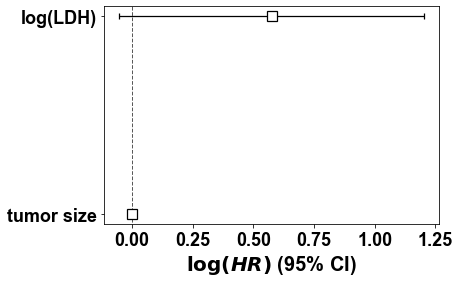


Mean (95% C.I) c-index in 5 fold cross-validation: 0.675 (0.663 - 0.688)


In [22]:
output_clinical = cox_regression(
    features_input = df[features_clinical],
    outcomes_input = df[['OS', "deces"]],
    duration_col='OS',
    event_col="deces",
    k_cross=5,
    n_repeats_cv=100,
    output_dir="cox_regression/os",
    signif_threshold=0.2,
    penalizer=0);

## Cox regression mechanistic + clinical parameters

In [23]:
# df['log_phi'] = np.log(df['phi'])
features = [
    "age",
    "sex",
#     "LDH",
    "log(LDH)",
#     "$\log(LDH)$",
    "SIOPEN",
    "MYCN",
    'tumor size',
#     "log(mu)",
     "$\log(\mu)$",
#     "log_phi"
    "visible threshold"
#     "MIBG_neg"
    ]
df['$\log(LDH)$'] = np.log(df['LDH'])

### Correlation matrix

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


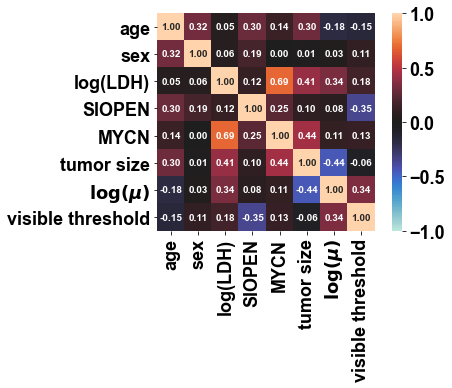

In [24]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# http://shakedzy.xyz/dython/modules/nominal/#associations
from dython.nominal import associations
fig, ax = plt.subplots();
corr = associations(df[features], nominal_columns=['sex', 'MYCN'], ax=ax)
fig.savefig('mechanistic/correlation_matrix.pdf', bbox_inches='tight')

### PFS

-----------------------------------------------------------------------
Individual features
-----------------------------------------------------------------------
age
p = 0.649
sex
p = 0.228
log(LDH)
p = 0.0385
SIOPEN
p = 0.0647
MYCN
p = 0.368
tumor size
p = 0.0651
$\log(\mu)$
p = 0.337
visible threshold
p = 0.243
-----------------------------------------------------------------------
All features multivariate
-----------------------------------------------------------------------
                   Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                               
age                       0.997  0.739            0.979             1.02
sex                        1.15  0.771            0.457             2.88
log(LDH)                   2.57 0.0493                1             6.59
SIOPEN                     1.01  0.386            0.982             1.05
MYCN                      0.831  0.804            0.192             3.59
tu

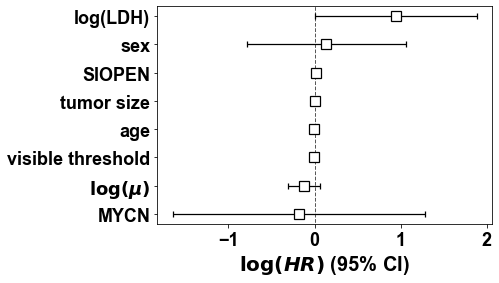


Mean (95% C.I) c-index in 5 fold cross-validation: 0.494 (0.48 - 0.508)
-----------------------------------------------------------------------
Only significant features in univariate (p < 0.2): 
['log(LDH)', 'SIOPEN', 'tumor size']
-----------------------------------------------------------------------
Only significant features
            Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                        
log(LDH)             1.6  0.116             0.89             2.89
SIOPEN              1.02 0.0637            0.999             1.04
tumor size             1  0.397                1                1


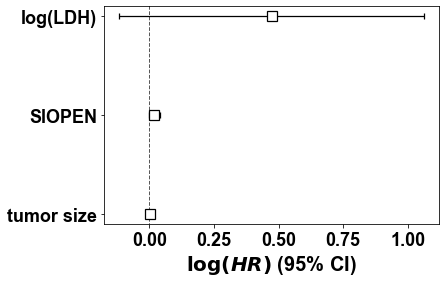


Mean (95% C.I) c-index in 5 fold cross-validation: 0.582 (0.568 - 0.595)
-----------------------------------------------------------------------
Only significant features in multivariate (p < 0.2): 
['log(LDH)', '$\\log(\\mu)$']
-----------------------------------------------------------------------
Only significant features
             Hazard ratio      p  coef lower 95\%  coef upper 95\%
covariate                                                         
log(LDH)             2.04 0.0135             1.16             3.58
$\log(\mu)$         0.895 0.0905            0.786             1.02


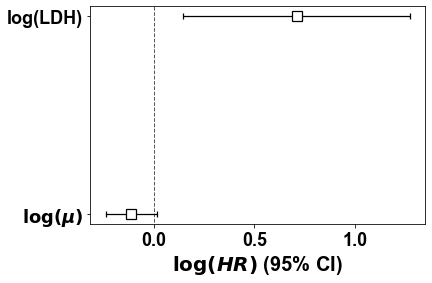


Mean (95% C.I) c-index in 5 fold cross-validation: 0.628 (0.615 - 0.641)


In [25]:
output_pfs = cox_regression(
    features_input = df[features],
    outcomes_input = df[['PFS', "progression"]],
    duration_col='PFS',
    event_col="progression",
    k_cross=5,
    n_repeats_cv=100,
    output_dir=output_dir_glob+"/cox_regression_mechanistic_clinical/pfs",
    signif_threshold=0.2,
    penalizer=0);

### OS

-----------------------------------------------------------------------
Individual features
-----------------------------------------------------------------------
age
p = 0.316
sex
p = 0.209
log(LDH)
p = 0.00794
SIOPEN
p = 0.297
MYCN
p = 0.184
tumor size
p = 0.00621
$\log(\mu)$
p = 0.126
visible threshold
p = 0.384
-----------------------------------------------------------------------
All features multivariate
-----------------------------------------------------------------------
                   Hazard ratio       p  coef lower 95\%  coef upper 95\%
covariate                                                                
age                           1   0.722            0.985             1.02
sex                        1.44   0.463             0.54             3.86
log(LDH)                   4.01 0.00562              1.5             10.7
SIOPEN                    0.999   0.963            0.966             1.03
MYCN                      0.477   0.346            0.102            

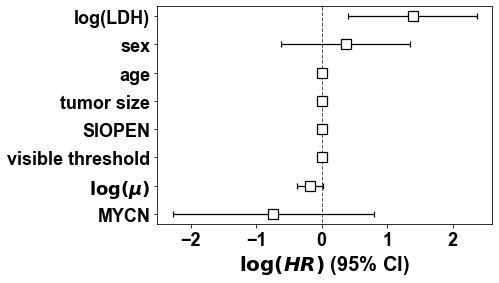


Mean (95% C.I) c-index in 5 fold cross-validation: 0.582 (0.567 - 0.597)
-----------------------------------------------------------------------
Only significant features in univariate (p < 0.2): 
['log(LDH)', 'MYCN', 'tumor size', '$\\log(\\mu)$']
-----------------------------------------------------------------------
Only significant features
             Hazard ratio       p  coef lower 95\%  coef upper 95\%
covariate                                                          
log(LDH)              4.2 0.00309             1.62             10.9
MYCN                0.431   0.188            0.123             1.51
tumor size              1   0.954            0.999                1
$\log(\mu)$         0.816  0.0307            0.679            0.981


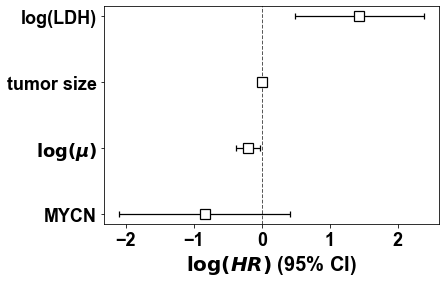


Mean (95% C.I) c-index in 5 fold cross-validation: 0.672 (0.659 - 0.685)
-----------------------------------------------------------------------
Only significant features in multivariate (p < 0.2): 
['log(LDH)', '$\\log(\\mu)$']
-----------------------------------------------------------------------
Only significant features
             Hazard ratio       p  coef lower 95\%  coef upper 95\%
covariate                                                          
log(LDH)             2.77 0.00129             1.49             5.16
$\log(\mu)$         0.832  0.0123             0.72            0.961


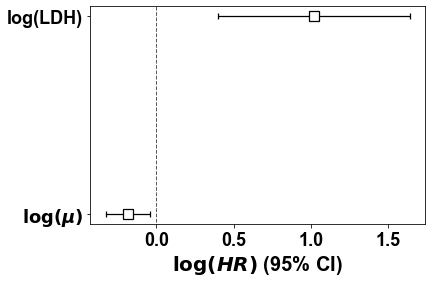


Mean (95% C.I) c-index in 5 fold cross-validation: 0.733 (0.722 - 0.744)


In [26]:
output = cox_regression(
    features_input = df[features],
    outcomes_input = df[['OS', "deces"]],
    duration_col='OS',
    event_col="deces",
    k_cross=5,
    n_repeats_cv=100,
    output_dir=output_dir_glob+"/cox_regression_mechanistic_clinical/os",
    signif_threshold=0.2,
    penalizer=0);

p-value for comparison of c-index

In [27]:
from scipy.stats import ttest_ind
# ttest_ind returns two-tailed p-value. Divide by 2 to obtain one-tailed p-value
t, p = ttest_ind(output_clinical['scores_k_fold_signif_multivariate'], output['scores_k_fold_signif_multivariate'])
p = p/2
print(p)

8.836785674362015e-12


# Cox score

In [29]:
if version.parse(lifelines.__version__) >= version.parse("0.22.0"):
    coef_names = 'params_'
else:
    coef_names = 'hazards_'

## PFS

/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


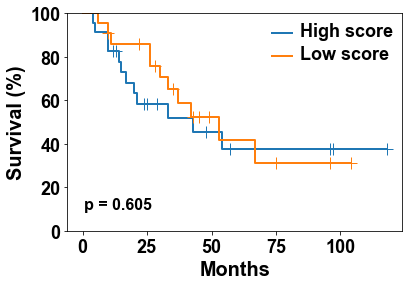

In [30]:
cph = output_pfs['cph_signif_univariate'] # signif_univariate = mutlivariate with features selected if signif in univariate
beta_s = getattr(cph, coef_names)
beta   = beta_s.values
X      = df[beta_s.index.tolist()].values
scores = np.sum(beta*X, axis=1)
df['score'] = scores
log_rank_threshold(
    df,
    'score',
    tte_name='OS',
    event_name='deces',
    ci_show=False,
    labels=['Low score', 'High score'],
    output_file="mechanistic/cox_regression_mechanistic_clinical/pfs/separation_cox_score")

## OS

/Users/benzekry/work/marseille/neuroblastome_andre/code_clean/code/stat_tools_python/survival_analysis.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100]);


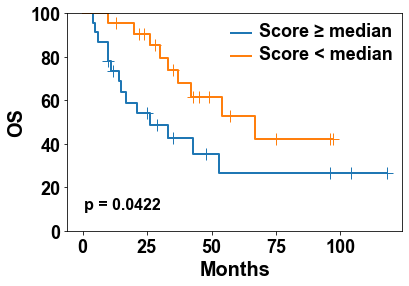

In [31]:
cph    = output['cph_signif_multivariate'] # signif_univariate = mutlivariate with features selected if signif in univariate
beta_s = getattr(cph, coef_names)
beta   = beta_s.values
X      = df[beta_s.index.tolist()].values
scores = np.sum(beta*X, axis=1)
df['score'] = scores
log_rank_threshold(
    df,
    'score',
    tte_name='OS',
    event_name='deces',
    ci_show=False,
    labels=['Score < median', 'Score ≥ median'],
    output_file="mechanistic/cox_regression_mechanistic_clinical/os/separation_cox_score",
    ylabel="OS"
)

# Export dataframe with values of mechanistic parameters

In [34]:
df.to_csv("mechanistic/data_and_parameters.csv")

# Plot distributions of relevant quantities

## Tumor age

In [32]:
model_s                            = model_m.Model()
model.parameters.visible_threshold = 5   # 118.5 # fitted at population level with sum min # 90 # 26.96
model.parameters.phi               = 1e-9 # 1.198e-9 # fitted at population level with sum min # 1e-9 # 4.565e-10

In [33]:
birth_times_first_mets = pd.read_csv("simulations/table_birth_times.csv", index_col="id")
for idx_patient in df.index:
#     print('------------------------------------------')
#     print('Patient %d' % idx_patient)
    data                               = model_m.Data()
    data.parse_df(df, idx_patient)
    model.parameters.visible_threshold   = df.loc[idx_patient, 'visible_threshold'] 
    model.parameters.mu                  = df.loc[idx_patient, 'mu']
    T_diag                               = model.time_to_size_PT(model.parameters, data.S_diag)
    df.loc[idx_patient, 'T_diag_days']   = T_diag
    birth_time_first_met                 = birth_times_first_mets.loc[idx_patient, 'birth_time_met_1']
    df.loc[idx_patient, 'birth_time_first_met'] = birth_time_first_met
    df.loc[idx_patient, 'age_first_met'] = T_diag - birth_time_first_met

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/table_birth_times.csv'

In [ ]:
df['T_diag_days'].describe()

In [ ]:
birth_times_first_mets.loc[24]

In [ ]:
birth_times_first_mets.loc[1]

In [ ]:
birth_times_first_mets.describe()

In [ ]:
df['visible threshold'].describe()

In [ ]:
sns.swarmplot(y=df['T_diag_days'])
sns.boxplot(y=df['T_diag_days'],
            showcaps=False,
            boxprops={'facecolor':'None'},
#             showfliers=False,
#             whiskerprops={'linewidth':0},
            width=0.2
           )
plt.ylabel('Age primary tumor (days)');

In [ ]:
sns.swarmplot(y=df['age_first_met'])
sns.boxplot(y=df['age_first_met'],
            showcaps=False,
            boxprops={'facecolor':'None'},
            width=0.2
           )
plt.ylabel('Age first met (days)');

In [ ]:
sns.swarmplot(y=df['birth_time_first_met'])
sns.boxplot(y=df['birth_time_first_met'],
            showcaps=False,
            boxprops={'facecolor':'None'},
            width=0.2
           )
plt.ylabel('Birth time first met (days)');

In [ ]:
# sns.set(font_scale = 1.5)
# df_plot = pd.DataFrame()
# df_plot['Age']    = df.copy()['T_diag_days']
# df_plot['Tumor']  = 'Primary'
# df_plot2          = pd.DataFrame()
# df_plot2['Age']   = df.copy()['age_first_met']
# df_plot2['Tumor'] = 'First met'
# df_plot           = pd.concat([df_plot, df_plot2], axis=0)
# ax                = sns.swarmplot(y='Age', x='Tumor', data=df_plot);
# ax.set_ylabel("Age (days)");
# ax.set_ylim(0, 85);

In [ ]:
# current_palette = sns.color_palette()
# ax = sns.swarmplot(y=df['birth_time_first_met'], color=current_palette[2])
# ax.set_ylabel("Birth time first met (days)")
# ax.set_ylim(0, 85);

In [ ]:
# ax                = sns.swarmplot(x='Age', y='Tumor', data=df_plot);

In [ ]:
# df_plot['Age']    = df.copy()['T_diag_days']
# df_plot['Tumor']  = 'Primary'
# df_plot3 = pd.DataFrame()
# df_plot3['Age'] = df.copy()['birth_time_first_met']
# df_plot3['Tumor'] = 'Birth time first met'
# df_plot = pd.concat([df_plot, df_plot3], axis=0)
# sns.swarmplot(x="Age", y="Tumor", data=df_plot)

In [ ]:
# df_plot           = pd.DataFrame()
# df_plot['Age']    = df.copy()['T_diag_days']
# df_plot['Tumor']  = 'Primary'
# df_plot3 = pd.DataFrame()
# df_plot3['Age'] = df.copy()['birth_time_first_met']
# df_plot3['Tumor'] = 'Birth time first met'
# df_plot = pd.concat([df_plot, df_plot3], axis=0)

# sns.set_context("talk")

# ax = sns.swarmplot(x="Age", y="Tumor", data=df_plot)
# ax.set_xlabel('Time (days)');
# ax.set_yticklabels([r'Diagnosis PT ($T_d$)', 'First met apparition ($T_{fm}$)'])
# ax.set_ylabel('')
# plt.savefig('simulations/time_frame.pdf', bbox_inches='tight')

# $\mu$ vs clinical parameters

Tumor size

In [ ]:
plt.plot(df['log(mu)'], df['tumor size'], 'o')

LDH

In [ ]:
plt.plot(df['log(mu)'], df['log(LDH)'], 'o')

SIOPEN

In [ ]:
plt.plot(df['log(mu)'], df['SIOPEN'], 'o')

# Additional

## Fit population

Fit all the patients together, with some parameters equal for all patients, and some patient specific. Several methods are possible:
- Summing all the individual log-likelihoods (global sum)
- Minimizing each log-likelihood individually for a given value of the population parameters, then summing the minimal log-likelihoods and minimizing this sum with respect to the population parameters (global sum min).

## Fit global sum

Settings

In [11]:
# param_opt_indiv_names_to_idx = {'mu': 0, 'phi': 1, 'visible_threshold': 2}
# param_opt_indiv_0            = [1e-11, 1e-10, 80]
# param_opt_pop_names_to_idx   = {}
# param_opt_pop_0              = [] # [80]

Launch fit

In [12]:
# model = model_m.Model()
# model.param_opt_indiv_names_to_idx = param_opt_indiv_names_to_idx
# model.param_opt_pop_names_to_idx   = param_opt_pop_names_to_idx
# param_fit_pop, params_fit_indivs, res = model_m.fit_SIOPEN_LDH_pop(
#     df,
#     model,
#     param_opt_pop_0,
#     param_opt_indiv_0,
#     disp_iter=True
#     )

In [13]:
# res.fun

## Fit global sum min

Settings

In [16]:
# param_opt_indiv_names_to_idx = {'mu': 0}
# param_opt_indiv_0            = [1e-11, 1e-10, 80]
# param_opt_pop_names_to_idx   = {'visible_threshold': 0, 'phi' : 1}
# param_opt_pop_0              = [90, 1e-9] # [80]

Launch fit

In [17]:
# model = model_m.Model()
# model.param_opt_indiv_names_to_idx = param_opt_indiv_names_to_idx
# model.param_opt_pop_names_to_idx   = param_opt_pop_names_to_idx
# param_fit_pop, l_pop_fit           = model_m.fit_SIOPEN_LDH_pop_sum_min(
#     df,
#     model,
#     param_opt_pop_0,
#     param_opt_indiv_0,
#     disp_iter=True
#     )